In [3]:
import torch
from torch import nn
import pandas as pd
import numpy as np

In [4]:
context_size = 7

In [5]:
df = pd.read_csv("./AMZN.csv")
data = df[["Date", "Close"]]

def gen_data_for_lstm(data_frame, context_size):
    for i in range(context_size):
        data_frame[f"Close t-{i+1}"] = data_frame["Close"].shift(i+1)
    data_frame = data_frame.iloc[context_size:]
    data_frame.set_index("Date", inplace=True)
    return data_frame
    
data = gen_data_for_lstm(data, 7)

/tmp/ipykernel_91904/1196380436.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[f"Close t-{i+1}"] = data_frame["Close"].shift(i+1)
/tmp/ipykernel_91904/1196380436.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[f"Close t-{i+1}"] = data_frame["Close"].shift(i+1)
/tmp/ipykernel_91904/1196380436.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [6]:
data

,Close,Close t-1,Close t-2,Close t-3,Close t-4,Close t-5,Close t-6,Close t-7
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [7]:
numpy_data = data.to_numpy()

#To feed this data to the lstm it must be feed in order
#From the oldest to the most recent data

numpy_data = np.fliplr(numpy_data)

#scale down the data to properly feed it to the lstm so it converges faster

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
numpy_data = scaler.fit_transform(numpy_data)
print(numpy_data)

[[-0.99969839 -0.99982128 -0.99983244 ... -1.         -0.99995531
  -0.99991063]
 [-0.99982128 -0.99983244 -0.99987154 ... -0.99994415 -0.99991063
  -0.99993855]
 [-0.99983244 -0.99987154 -0.99998325 ... -0.99989946 -0.99993855
  -0.99995253]
 ...
 [ 0.05779984  0.05158     0.0506149  ...  0.09308121  0.10690997
   0.09747299]
 [ 0.05158     0.0506149   0.04203581 ...  0.10691495  0.09747299
   0.11398769]
 [ 0.0506149   0.04203581  0.07431453 ...  0.09747802  0.11398769
   0.08342464]]


In [8]:
inputs = numpy_data[:, :-1]
labels = numpy_data[:, -1].reshape(len(inputs), 1)
print(inputs.shape)
print(labels.shape)

(6509, 7)
(6509, 1)


In [9]:
print(labels)

[[-0.99991063]
 [-0.99993855]
 [-0.99995253]
 ...
 [ 0.09747299]
 [ 0.11398769]
 [ 0.08342464]]


In [40]:
train_percent = 0.95
train_split = int(len(inputs) * train_percent)

train_inputs = inputs[:train_split]
train_labels = labels[:train_split]

test_inputs = inputs[train_split:]
test_labels = labels[train_split:]

In [41]:
train_inputs = torch.tensor(train_inputs).unsqueeze(-1).type(torch.float32)
test_inputs = torch.tensor(test_inputs).unsqueeze(-1).type(torch.float32)

train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)




train_dataset = torch.utils.data.TensorDataset(train_inputs.type(torch.float32), train_labels.type(torch.float32))
test_dataset = torch.utils.data.TensorDataset(test_inputs.type(torch.float32), test_labels.type(torch.float32))

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)


In [42]:
print(train_inputs.shape)
print(test_inputs.shape)

torch.Size([6183, 7, 1])
torch.Size([326, 7, 1])


In [43]:
class LSTM(nn.Module):
    def __init__(self, inputs_size, hidden_size, n_stacked_layers):
        super(LSTM, self).__init__()
        
        self.inputs_size = inputs_size
        self.hidden_size = hidden_size
        self.n_stacked_layers = n_stacked_layers

        self.lstm = nn.LSTM(inputs_size, hidden_size, n_stacked_layers, batch_first=True)
        self.fully_connected = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]

        #need to pass in the hidden states for the long memory and short memory
        h0 = torch.zeros((self.n_stacked_layers, batch_size, self.hidden_size))
        c0 = torch.zeros((self.n_stacked_layers, batch_size, self.hidden_size))

        out, _ = self.lstm(x, (h0, c0))
        out = self.fully_connected(out[:, -1, :])
        return out

In [44]:
from tqdm import tqdm
model = LSTM(1, 4, 1)

lr = 0.1
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [49]:
epochs = 10
for epoch in tqdm(range(epochs)):
    for x, y in train_dataloader:
        preds = model(x)
        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
print(loss)

100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

tensor(3.6890e-05, grad_fn=<MseLossBackward0>)


In [51]:
import matplotlib.pyplot as plt

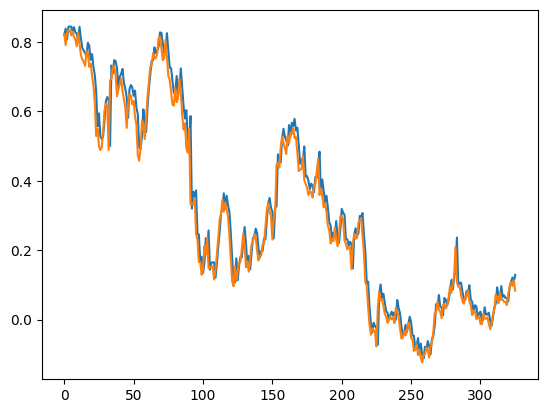

In [80]:

with torch.inference_mode():
    preds = model(test_inputs)


plt.plot(preds)
plt.plot(test_labels)